<a href="https://colab.research.google.com/github/srivardhini-reddy/Fine-Tuning-LLMs-for-Emotion-Dectection/blob/main/Google%20Gemma%20finetuned%20on%20Emotion%20Data%20using%20LORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  !pip install transformers evaluate wandb datasets accelerate peft -U -qq ## NEW LINES ##


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [2]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
!pip install datasets
from datasets import load_dataset
from transformers import (
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
)
!pip install wandb
!pip install evaluate
import wandb
import evaluate
!pip install peft
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

In [3]:
from datasets import load_dataset

emotion_data= load_dataset("harpreetmann/train_emotion_spring_2024")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6179 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [4]:
emotion_data['train'][0:2]

{'text': ['Does anyone know, are both Sims in a dual sim phone both locked to the same network! #worry',
  'A not very young man compiled info on a smiling baby then a mattress created new evil.'],
 'label': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

In [5]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [6]:
from huggingface_hub import login
login()

In [7]:
checkpoint = "google/gemma-1.1-2b-it"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [8]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [9]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [10]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

In [11]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits= logits[0]
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

In [27]:

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-6,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(r'/content/drive/MyDrive'),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'emotion_detection_gemma_lora',  # Experiment name for Weights & Biases


)


In [30]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification"
                                                           )

model = prepare_model_for_kbit_training(model)

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config
model.config.pad_token_id = tokenizer.pad_token_id
model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    

In [14]:
model.config

GemmaConfig {
  "_name_or_path": "google/gemma-1.1-2b-it",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 1,

In [15]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['v_proj',
 'k_proj',
 'o_proj',
 'score',
 'gate_proj',
 'q_proj',
 'up_proj',
 'down_proj']

In [16]:
gemmalora_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    modules_to_save = ['score'],
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

gemma_lora_model = get_peft_model(model, gemmalora_peft_config )
# mistral_qlora_model.config.pad_token_id = tokenizer.pad_token_id
# mistral_qlora_model.resize_token_embeddings(len(tokenizer))
gemma_lora_model.print_trainable_parameters()

trainable params: 156,915,712 || all params: 2,663,110,656 || trainable%: 5.892196467558275


In [17]:
gemmalora_peft_config.target_modules

{'down_proj', 'gate_proj', 'k_proj', 'o_proj', 'q_proj', 'up_proj', 'v_proj'}

In [18]:
gemmalora_peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='google/gemma-1.1-2b-it', revision=None, task_type=<TaskType.SEQ_CLS: 'SEQ_CLS'>, inference_mode=False, r=128, target_modules={'v_proj', 'k_proj', 'o_proj', 'gate_proj', 'q_proj', 'up_proj', 'down_proj'}, lora_alpha=256, lora_dropout=0.01, fan_in_fan_out=False, bias='lora_only', use_rslora=False, modules_to_save=['score'], init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [19]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)


In [20]:
pos_weights

tensor([ 1.6795,  5.9349,  1.6519,  4.7002,  1.6947,  8.4192,  2.3988,  7.6541,
         2.3400, 18.6783, 19.1928])

In [21]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [22]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [23]:
gemma_lora_model.config

GemmaConfig {
  "_name_or_path": "google/gemma-1.1-2b-it",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 1,

In [28]:
trainer = CustomTrainer(
    model=gemma_lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [25]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_S2024

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=emotions_kaggle_S2024


In [29]:
trainer.train()

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.793700,0.815015,0.432291,0.300112,0.037540
40,0.741300,0.748878,0.501001,0.349853,0.071845
60,0.687100,0.686996,0.546144,0.400447,0.099029
80,0.656200,0.636082,0.592538,0.454636,0.113269
100,0.606200,0.606155,0.613753,0.477721,0.130097
120,0.539600,0.593019,0.632840,0.492977,0.151456
140,0.511500,0.587699,0.629805,0.505030,0.148867
160,0.504100,0.577189,0.638265,0.513724,0.155340
180,0.494500,0.568905,0.647209,0.528108,0.159223
200,0.478800,0.561067,0.653287,0.536774,0.176699


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.793700,0.815015,0.432291,0.300112,0.037540
40,0.741300,0.748878,0.501001,0.349853,0.071845
60,0.687100,0.686996,0.546144,0.400447,0.099029
80,0.656200,0.636082,0.592538,0.454636,0.113269
100,0.606200,0.606155,0.613753,0.477721,0.130097
120,0.539600,0.593019,0.632840,0.492977,0.151456
140,0.511500,0.587699,0.629805,0.505030,0.148867
160,0.504100,0.577189,0.638265,0.513724,0.155340
180,0.494500,0.568905,0.647209,0.528108,0.159223
200,0.478800,0.561067,0.653287,0.536774,0.176699


KeyboardInterrupt: 

In [30]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.793700,0.815015,0.432291,0.300112,0.037540
40,0.741300,0.748878,0.501001,0.349853,0.071845
60,0.687100,0.686996,0.546144,0.400447,0.099029
80,0.656200,0.636082,0.592538,0.454636,0.113269
100,0.606200,0.606155,0.613753,0.477721,0.130097
120,0.539600,0.593019,0.632840,0.492977,0.151456
140,0.511500,0.587699,0.629805,0.505030,0.148867
160,0.504100,0.577189,0.638265,0.513724,0.155340
180,0.494500,0.568905,0.647209,0.528108,0.159223
200,0.478800,0.561067,0.653287,0.536774,0.176699


In [31]:
eval_results

{'eval_loss': 0.5679686665534973,
 'eval_f1_micro': 0.6575800437186576,
 'eval_f1_macro': 0.5382193468329711,
 'eval_accuracy': 0.17411003236245956}

In [32]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

In [33]:
valid_output = trainer.predict(tokenized_dataset["valid"])

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.793700,0.815015,0.432291,0.300112,0.037540
40,0.741300,0.748878,0.501001,0.349853,0.071845
60,0.687100,0.686996,0.546144,0.400447,0.099029
80,0.656200,0.636082,0.592538,0.454636,0.113269
100,0.606200,0.606155,0.613753,0.477721,0.130097
120,0.539600,0.593019,0.632840,0.492977,0.151456
140,0.511500,0.587699,0.629805,0.505030,0.148867
160,0.504100,0.577189,0.638265,0.513724,0.155340
180,0.494500,0.568905,0.647209,0.528108,0.159223
200,0.478800,0.561067,0.653287,0.536774,0.176699


In [34]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

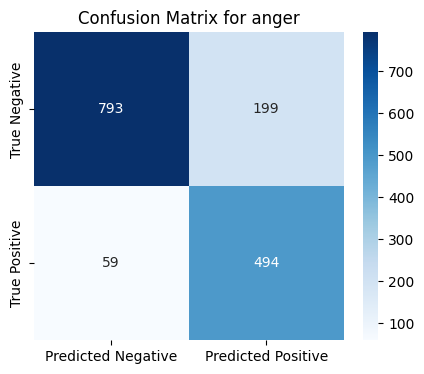

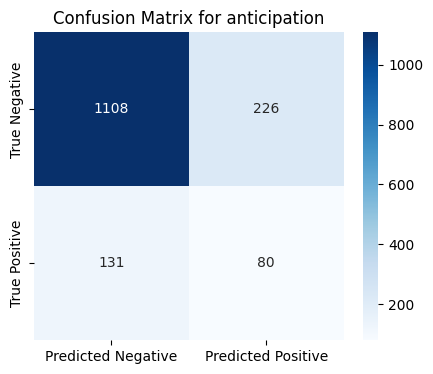

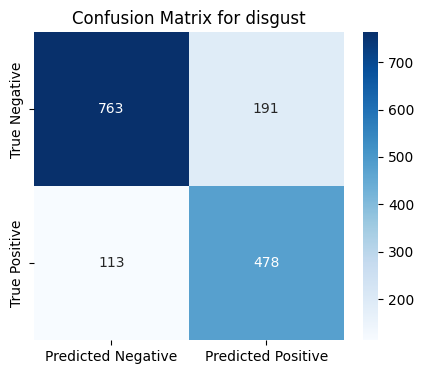

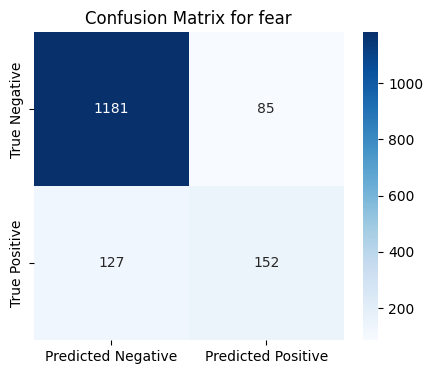

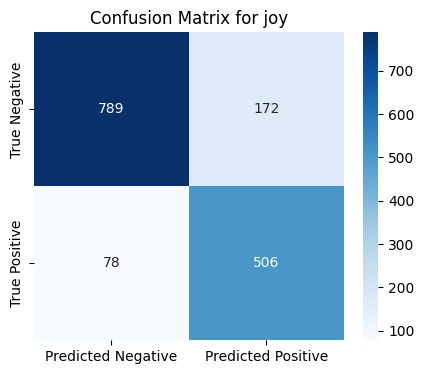

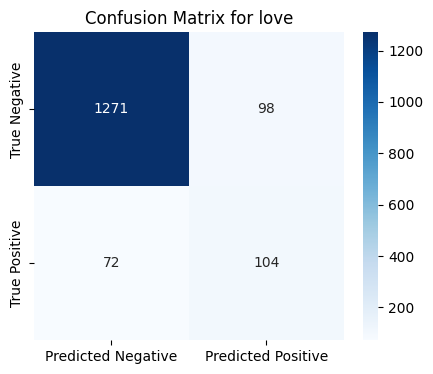

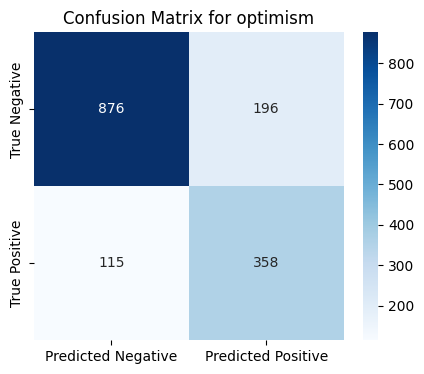

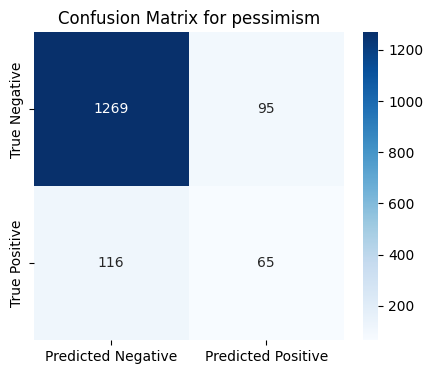

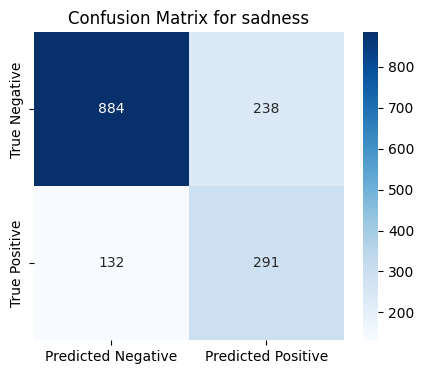

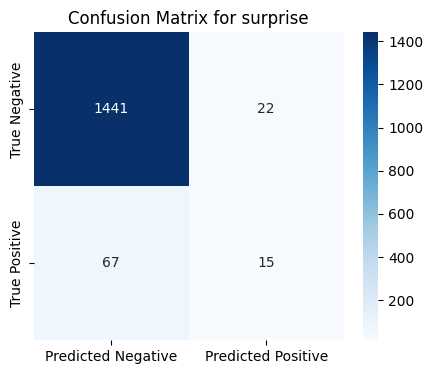

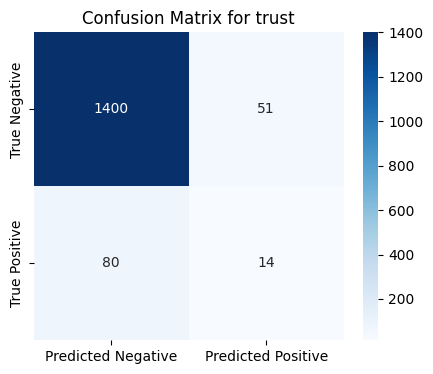

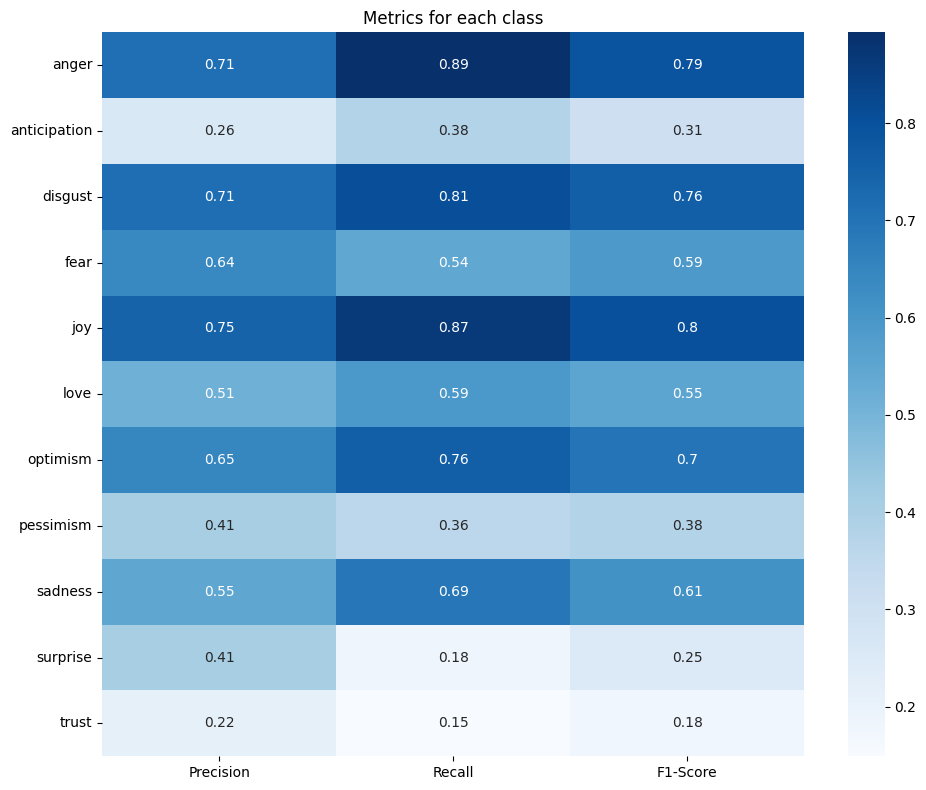

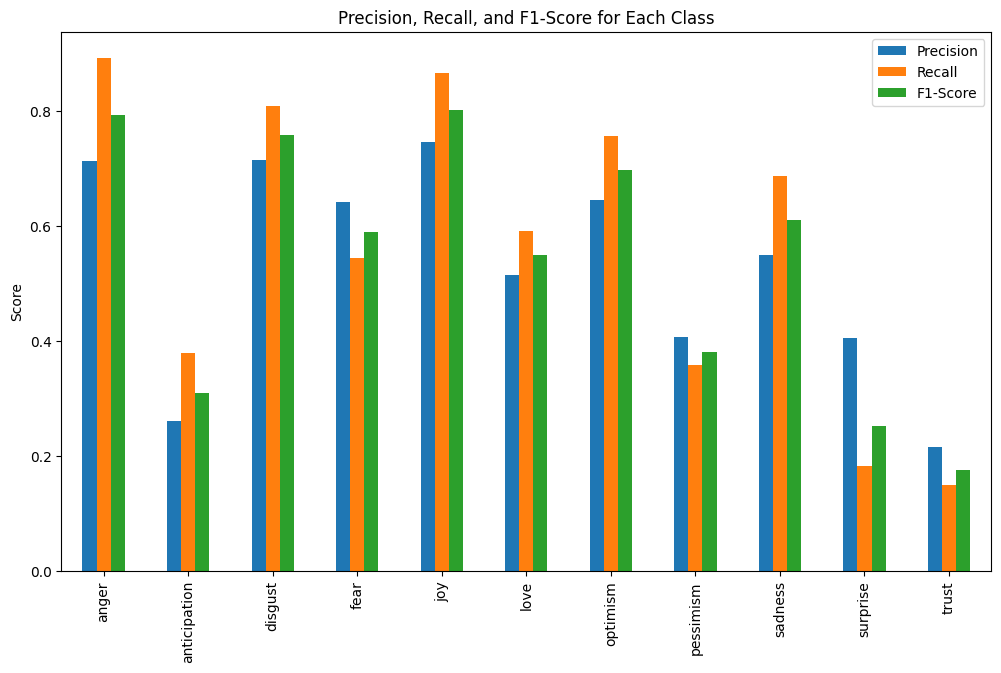

In [35]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




In [36]:
wandb.finish()

eval/accuracy,▁▂▃▅▅▆▇▇▇▇███
eval/f1_macro,▁▁▃▄▆▆▇▇▇████
eval/f1_micro,▁▂▄▅▆▇▇▇█████
eval/loss,█▆▅▄▃▂▂▂▁▁▁▁▁
eval/runtime,▁▇▇▇▇▇▇▇▇▇█▇█
eval/samples_per_second,█▂▂▂▂▂▂▂▂▂▁▂▁
eval/steps_per_second,▁████████████
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


In [37]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

In [38]:
from huggingface_hub import login
login()


In [39]:
gemma_lora_model.push_to_hub("srivardhinireddy/gemma_LORA_model_emotion_detection")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/628M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/srivardhinireddy/gemma_LORA_model_emotion_detection/commit/2423f0ea9b9d103d2fcf42bcb7cfa4387e6cda4e', commit_message='Upload model', commit_description='', oid='2423f0ea9b9d103d2fcf42bcb7cfa4387e6cda4e', pr_url=None, pr_revision=None, pr_num=None)

In [40]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

peft_model_id = "srivardhinireddy/gemma_LORA_model_emotion_detection"
config = PeftConfig.from_pretrained(peft_model_id)
config.base_model_name_or_path

base_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=11,
    problem_type="multi_label_classification"
)

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Now you can load the PEFT model without quantization
inference_model = PeftModel.from_pretrained(base_model, peft_model_id)

adapter_config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/628M [00:00<?, ?B/s]

In [41]:
config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='google/gemma-1.1-2b-it', revision=None, task_type='SEQ_CLS', inference_mode=True, r=128, target_modules={'v_proj', 'k_proj', 'o_proj', 'gate_proj', 'q_proj', 'up_proj', 'down_proj'}, lora_alpha=256, lora_dropout=0.01, fan_in_fan_out=False, bias='lora_only', use_rslora=False, modules_to_save=['score'], init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [42]:
base_model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.01, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2048, out_features=128, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=128, out_features=2048, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=256, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.0

In [43]:
inference_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GemmaForSequenceClassification(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
   

In [44]:
test_filepath = '/content/test.csv'
test_df = pd.read_csv(test_filepath)

In [45]:
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
for label in label_columns:
    test_df[label] = test_df[label].apply(lambda x: 0 if x == 'NONE' else 1)
test_df['labels'] = test_df[label_columns].values.tolist()
test_df['labels'] = test_df['labels'].apply(lambda labels: [float(label) for label in labels])

In [46]:
from datasets import Dataset
# Convert DataFrame to Hugging Face dataset format
test_dataset = Dataset.from_pandas(test_df)

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["Tweet"], padding="max_length", truncation=True, max_length=128)

test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [47]:
# Function to convert logits to probabilities
def convert_to_probabilities(logits):
    # Apply sigmoid function to convert logits to probabilities
    probabilities = torch.sigmoid(torch.tensor(logits)).detach().numpy()
    return probabilities

# Function to determine binary predictions based on a threshold
def determine_binary_predictions(probabilities, threshold=0.5):
    predicted_labels = []
    for prob in probabilities:
        # Select labels with probabilities above the threshold
        labels = [i for i, p in enumerate(prob) if p > threshold]
        if not labels:  # If no labels are selected above threshold
            # Get indices of top 2 probabilities
            top_2_indices = np.argsort(prob)[-2:]
            # Reset binary predictions
            binary_prediction = np.zeros_like(prob, dtype=int)
            # Select the top 2 labels
            binary_prediction[top_2_indices] = 1
            labels = list(binary_prediction)
        else:
            binary_prediction = np.zeros_like(prob, dtype=int)
            binary_prediction[labels] = 1
            labels = list(binary_prediction)
        predicted_labels.append(labels)
    return predicted_labels

# Example usage:
# Assuming `trainer.predict(test_dataset)` returns logits
test_predictions = trainer.predict(test_dataset)
probabilities = convert_to_probabilities(test_predictions.predictions)
predicted_labels = determine_binary_predictions(probabilities, threshold=0.5)

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.793700,0.815015,0.432291,0.300112,0.037540
40,0.741300,0.748878,0.501001,0.349853,0.071845
60,0.687100,0.686996,0.546144,0.400447,0.099029
80,0.656200,0.636082,0.592538,0.454636,0.113269
100,0.606200,0.606155,0.613753,0.477721,0.130097
120,0.539600,0.593019,0.632840,0.492977,0.151456
140,0.511500,0.587699,0.629805,0.505030,0.148867
160,0.504100,0.577189,0.638265,0.513724,0.155340
180,0.494500,0.568905,0.647209,0.528108,0.159223
200,0.478800,0.561067,0.653287,0.536774,0.176699


In [48]:
submission_ids = test_df['ID']  # Assuming 'test_df' has an 'ID' column

# Create the submission DataFrame
submission_df = pd.DataFrame(predicted_labels, columns=label_columns)
submission_df.insert(0, 'ID', submission_ids)

In [49]:
submission_df

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,0,1,0,0,0,0,0,0,0,0
1,2018-03739,1,0,0,0,0,0,0,0,1,0,0
2,2018-00385,1,0,1,0,0,0,0,0,1,0,0
3,2018-03001,0,1,0,1,0,0,0,1,1,0,0
4,2018-01988,1,0,1,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,1,0,1,0,0,0,0,0,0,0,0
3255,2018-00416,0,1,0,1,1,0,1,0,0,0,0
3256,2018-03717,1,0,1,0,1,0,0,0,0,0,0
3257,2018-03504,0,1,0,0,1,0,1,0,0,0,0


In [50]:
# Path to save the submission file
submission_path = '/content/drive/MyDrive/submission-gemma_lora.csv'

# Save submission DataFrame to CSV
submission_df.to_csv(submission_path, index=False)